<a href="https://colab.research.google.com/github/casaArseniy/OS_CMR-SS-SAX-NN-HEALTHY-VS-ICMP/blob/main/3DCNN_OS_CMR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import PIL.Image

# 3D CNN Neural Network

# Imports

In [ ]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds
import imageio
import matplotlib.pyplot as plt

In [ ]:
print(tf.__version__)

2.15.0


# Load and Check Data and Batching Data

In [ ]:
def load_data_and_label(index):
    if index <= 60:
    # if index <= 32:
      data =  np.load(f'/content/drive/MyDrive/DL_CMR_ORG_IMG_STACK/Healthy/{index}.npy')
      # data = np.load(f'/content/drive/MyDrive/DL_CMR_NP/Healthy_NP/{index}.npy')
      # data = np.load(f'/content/drive/MyDrive/DL_CMR_MALE_ONLY/Healthy/{index}.npy')
      label = 0
    # else:
    elif index < 121:
      index = index - 60
      # index = index - 32
      data =  np.load(f'/content/drive/MyDrive/DL_CMR_ORG_IMG_STACK/ICMP/{index}.npy')
      # data = np.load(f'/content/drive/MyDrive/DL_CMR_NP/ICMP_NP/{index}.npy')
      # data = np.load(f'/content/drive/MyDrive/DL_CMR_MALE_ONLY/ICMP/{index}.npy')
      label = 1

    if data.shape[0] > 20:
      data = data[0:20 :, :]

    # if image is not right size, padd the image
    if data.shape[1]<256 and data.shape[2]<256:
      target_size = (20, 256, 256)
      padded_img = np.ones(target_size)
      padded_img[:data.shape[0], :data.shape[1], :data.shape[2]] = data
      data = padded_img

    return data/255, label

# Function to flip the data
def flip_data_left_right(data, label):
    # Flip along the vertical axis
    data = tf.convert_to_tensor(data)
    data = tf.image.flip_left_right(data)
    return data, label

def flip_data_up_down(data, label):
  data = tf.convert_to_tensor(data)
  data = tf.image.flip_up_down(data)
  return data, label

In [ ]:
# num_samples = 86
num_samples = 121
# num_samples = 153
indices = tf.data.Dataset.range(1, num_samples)
dataset = indices.map(lambda x: tf.numpy_function(load_data_and_label, [x], (tf.double, tf.int64)))

In [ ]:
seed_value = 42
# Shuffle the dataset
dataset = dataset.shuffle(buffer_size=num_samples, seed=seed_value)  # Shuffle the dataset

In [ ]:
import keras

In [ ]:
train_dataset, right_ds = keras.utils.split_dataset(dataset, left_size=0.5)
test_dataset, val_dataset = keras.utils.split_dataset(right_ds, left_size=0.6)

In [ ]:
train_dataset_size = tf.data.experimental.cardinality(train_dataset).numpy()
val_dataset_size = tf.data.experimental.cardinality(val_dataset).numpy()
test_dataset_size = tf.data.experimental.cardinality(test_dataset).numpy()


print("Size of train dataset:", train_dataset_size)
print("Size of val dataset:", val_dataset_size)
print("Size of test dataset:", test_dataset_size)

Size of train dataset: 60
Size of val dataset: 24
Size of test dataset: 36


In [ ]:
train_dataset = train_dataset.concatenate(train_dataset.map(flip_data_left_right).take(train_dataset_size))
train_dataset_size = tf.data.experimental.cardinality(train_dataset).numpy()
train_dataset = train_dataset.concatenate(train_dataset.map(flip_data_up_down).take(train_dataset_size))

train_dataset_size = tf.data.experimental.cardinality(train_dataset).numpy()
val_dataset_size = tf.data.experimental.cardinality(val_dataset).numpy()
test_dataset_size = tf.data.experimental.cardinality(test_dataset).numpy()

print("Size of augmented train dataset:", train_dataset_size)
print("Size of val dataset:", val_dataset_size)
print("Size of test dataset:", test_dataset_size)

Size of augmented train dataset: 304
Size of val dataset: 30
Size of test dataset: 46


## TESTING FOR DATA LEAK

In [ ]:
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)


In [ ]:
val_dataset = val_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)


In [ ]:
test_dataset = test_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [ ]:
loop = 0
for tr_arr in train_dataset:
  tr_data, tr_label = tr_arr
  val = 0
  for val_arr in val_dataset:
    print(f'\rLoop {loop}/{train_dataset_size} tst: {val}/{val_dataset_size}', end='', flush=True)
    val_data, val_label = val_arr
    if np.array_equal(tr_data, val_data):
      print("LEAK AT train:", loop, " and val", val)
    val+=1
  loop+=1

Loop 75/76 tst: 29/30

In [ ]:
loop = 0
for tr_arr in train_dataset:
  val = 0
  for tst_arr in test_dataset:
    print(f'\rLoop {loop}/{train_dataset_size} val: {val}/{test_dataset_size}', end='', flush=True)
    if np.array_equal(tr_arr, tst_arr):
      print("LEAK!!!")
      break
    val+=1
  loop+=1

In [ ]:
loop = 0
for val_arr in val_dataset:
  val = 0
  val_data, val_label = val_arr
  for tst_arr in test_dataset:
    tst_data, tst_label = tst_arr
    print(f'\rLoop {loop}/{val_dataset_size} tst: {val}/{test_dataset_size}', end='', flush=True)
    if np.array_equal(val_data, tst_data):
      print("LEAK AT val:", loop, " and test", val)
    val+=1
  loop+=1

Loop 29/30 tst: 45/46

## Batching

In [ ]:
# Batch the datasets
batch_size = 8 # 8, 16, 32
train_dataset = train_dataset.batch(batch_size)
test_dataset = test_dataset.batch(batch_size)
val_dataset = val_dataset.batch(batch_size)

In [ ]:
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

# Now you can iterate over the dataset in your training loop
for batch_data, batch_labels in train_dataset:
  print(batch_data.shape)
  print(batch_labels)

(8, 20, 256, 256)
tf.Tensor([1 1 1 0 0 1 1 1], shape=(8,), dtype=int64)
(8, 20, 256, 256)
tf.Tensor([0 0 1 1 0 1 0 1], shape=(8,), dtype=int64)
(8, 20, 256, 256)
tf.Tensor([0 0 0 0 0 1 0 1], shape=(8,), dtype=int64)
(8, 20, 256, 256)
tf.Tensor([0 1 1 1 1 1 1 1], shape=(8,), dtype=int64)
(8, 20, 256, 256)
tf.Tensor([0 1 1 1 1 0 1 1], shape=(8,), dtype=int64)
(8, 20, 256, 256)
tf.Tensor([0 0 0 1 0 0 0 1], shape=(8,), dtype=int64)
(8, 20, 256, 256)
tf.Tensor([1 1 1 0 0 1 0 0], shape=(8,), dtype=int64)
(4, 20, 256, 256)
tf.Tensor([0 0 1 0], shape=(4,), dtype=int64)


In [ ]:
test_dataset = test_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

# Now you can iterate over the dataset in your training loop
for batch_data, batch_labels in test_dataset:
  print(batch_data.shape)
  print(batch_labels)

(8, 20, 256, 256)
tf.Tensor([0 1 1 1 0 0 1 0], shape=(8,), dtype=int64)
(8, 20, 256, 256)
tf.Tensor([0 0 0 0 0 1 1 0], shape=(8,), dtype=int64)
(8, 20, 256, 256)
tf.Tensor([0 1 1 1 0 1 1 1], shape=(8,), dtype=int64)
(8, 20, 256, 256)
tf.Tensor([1 1 1 1 0 0 0 0], shape=(8,), dtype=int64)
(4, 20, 256, 256)
tf.Tensor([0 1 0 0], shape=(4,), dtype=int64)


In [ ]:
val_dataset = val_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

# Now you can iterate over the dataset in your training loop
for batch_data, batch_labels in val_dataset:
  print(batch_data.shape)
  print(batch_labels)

(8, 20, 256, 256)
tf.Tensor([1 1 0 1 0 0 0 0], shape=(8,), dtype=int64)
(8, 20, 256, 256)
tf.Tensor([0 1 1 0 0 0 1 1], shape=(8,), dtype=int64)
(8, 20, 256, 256)
tf.Tensor([1 0 0 1 1 1 0 0], shape=(8,), dtype=int64)


# Model and Single Run

#### 256x256 model

In [ ]:
tf.random.set_seed(seed_value)

l2_regularizer = tf.keras.regularizers.L2(0.05)  # L2 regularization with a penalty factor of 0.01
l1_regularizer = tf.keras.regularizers.L1(0.01)  # L1 regularization with a penalty factor of 0.01

model = tf.keras.Sequential([
    tf.keras.layers.Conv3D(filters=32, kernel_size=(3, 3, 3), activation='relu', input_shape=(20, 256, 256, 1), padding='same', kernel_regularizer=l2_regularizer),
    tf.keras.layers.MaxPooling3D(pool_size=(2, 2, 2)),
    tf.keras.layers.Conv3D(filters=32, kernel_size=(3, 3, 3), activation='relu', padding = 'same', kernel_regularizer=l2_regularizer),
    tf.keras.layers.MaxPooling3D(pool_size=(2, 2, 2)),
    tf.keras.layers.Conv3D(filters=32, kernel_size=(3, 3, 3), activation='relu', padding='same', kernel_regularizer=l2_regularizer),
    tf.keras.layers.MaxPooling3D(pool_size=(2, 2, 2)),
    tf.keras.layers.Conv3D(filters=32, kernel_size=(3, 3, 3), activation='relu', padding='same', kernel_regularizer=l2_regularizer),
    tf.keras.layers.MaxPooling3D(pool_size=(2, 2, 2)),
    tf.keras.layers.Flatten(),

    # # Add dropout layers to prevent overfitting
    # tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=l2_regularizer),
    # tf.keras.layers.Dropout(0.5),  # Dropout with 50% rate
    # tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=l2_regularizer),
    # tf.keras.layers.Dropout(0.5),  # Dropout with 50% rate
    # tf.keras.layers.Dense(16, activation='relu', kernel_regularizer=l2_regularizer),
    # tf.keras.layers.Dense(1, activation='sigmoid', kernel_regularizer=l2_regularizer)  # Binary output

    # Add dropout layers to prevent overfitting
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),  # Dropout with 50% rate
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.5),  # Dropout with 50% rate
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')  # Binary output
])


# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',  # Binary cross-entropy loss for binary classification
              metrics=['accuracy'],
              run_eagerly=True)

# Print model summary
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv3d_4 (Conv3D)                    │ (None, 20, 256, 256, 32)    │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_4 (MaxPooling3D)       │ (None, 10, 128, 128, 32)    │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_5 (Conv3D)                    │ (None, 10, 128, 128, 32)    │          27,680 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_5 (MaxPooling3D)       │ (None, 5, 64, 64, 32)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_6 (Conv3D)                    │ (None, 5, 64, 64, 32)       │          27,680 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_6 (MaxPooling3D)       │ (None, 2, 32, 32, 32)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_7 (Conv3D)                    │ (None, 2, 32, 32, 32)       │          27,680 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_7 (MaxPooling3D)       │ (None, 1, 16, 16, 32)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 64)                  │         524,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 610,913 (2.33 MB)

 Trainable params: 610,913 (2.33 MB)

 Non-trainable params: 0 (0.00 B)

#### 60x60 model

In [ ]:
tf.random.set_seed(seed_value)

l2_regularizer = tf.keras.regularizers.L2(0.05)  # L2 regularization with a penalty factor of 0.01
l1_regularizer = tf.keras.regularizers.L1(0.01)  # L1 regularization with a penalty factor of 0.01

model2 = tf.keras.Sequential([
    tf.keras.layers.Conv3D(filters=32, kernel_size=(3, 3, 3), activation='relu', input_shape=(20, 60, 60, 1), padding='same', kernel_regularizer=l2_regularizer),
    tf.keras.layers.MaxPooling3D(pool_size=(2, 2, 2)),
    tf.keras.layers.Conv3D(filters=32, kernel_size=(3, 3, 3), activation='relu', padding = 'same', kernel_regularizer=l2_regularizer),
    tf.keras.layers.MaxPooling3D(pool_size=(2, 2, 2)),
    tf.keras.layers.Conv3D(filters=32, kernel_size=(3, 3, 3), activation='relu', padding='same', kernel_regularizer=l2_regularizer),
    tf.keras.layers.MaxPooling3D(pool_size=(2, 2, 2)),
    tf.keras.layers.Conv3D(filters=32, kernel_size=(3, 3, 3), activation='relu', padding='same', kernel_regularizer=l2_regularizer),
    tf.keras.layers.MaxPooling3D(pool_size=(2, 2, 2)),
    tf.keras.layers.Flatten(),

    # # Add dropout layers to prevent overfitting
    # tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=l2_regularizer),
    # tf.keras.layers.Dropout(0.5),  # Dropout with 50% rate
    # tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=l2_regularizer),
    # tf.keras.layers.Dropout(0.5),  # Dropout with 50% rate
    # tf.keras.layers.Dense(16, activation='relu', kernel_regularizer=l2_regularizer),
    # tf.keras.layers.Dense(1, activation='sigmoid', kernel_regularizer=l2_regularizer)  # Binary output

    # Add dropout layers to prevent overfitting
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),  # Dropout with 50% rate
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.5),  # Dropout with 50% rate
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')  # Binary output
])


# Compile the model
model2.compile(optimizer='adam',
              loss='binary_crossentropy',  # Binary cross-entropy loss for binary classification
              metrics=['accuracy'],
              run_eagerly=True)

# Print model summary
model2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv3d_4 (Conv3D)                    │ (None, 20, 60, 60, 32)      │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_4 (MaxPooling3D)       │ (None, 10, 30, 30, 32)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_5 (Conv3D)                    │ (None, 10, 30, 30, 32)      │          27,680 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_5 (MaxPooling3D)       │ (None, 5, 15, 15, 32)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_6 (Conv3D)                    │ (None, 5, 15, 15, 32)       │          27,680 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_6 (MaxPooling3D)       │ (None, 2, 7, 7, 32)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_7 (Conv3D)                    │ (None, 2, 7, 7, 32)         │          27,680 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_7 (MaxPooling3D)       │ (None, 1, 3, 3, 32)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 288)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 64)                  │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 105,057 (410.38 KB)

 Trainable params: 105,057 (410.38 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
tf.random.set_seed(seed_value)

# Define the model
model = tf.keras.Sequential([
    tf.keras.layers.Conv3D(filters=32, kernel_size=(3, 3, 3), activation='relu', input_shape=(20, 60, 60, 1), padding='same'),
    tf.keras.layers.MaxPooling3D(pool_size=(2, 2, 2)),
    tf.keras.layers.Conv3D(filters=64, kernel_size=(3, 3, 3), activation='relu', padding = 'same'),
    tf.keras.layers.MaxPooling3D(pool_size=(2, 2, 2)),
    tf.keras.layers.Conv3D(filters=128, kernel_size=(3, 3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling3D(pool_size=(2, 2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')  # Binary output
])

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',  # Binary cross-entropy loss for binary classification
              metrics=['accuracy'],
              run_eagerly=True)

# Print model summary
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv3d (Conv3D)                      │ (None, 20, 60, 60, 32)      │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d (MaxPooling3D)         │ (None, 10, 30, 30, 32)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_1 (Conv3D)                    │ (None, 10, 30, 30, 64)      │          55,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_1 (MaxPooling3D)       │ (None, 5, 15, 15, 64)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_2 (Conv3D)                    │ (None, 5, 15, 15, 128)      │         221,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_2 (MaxPooling3D)       │ (None, 2, 7, 7, 128)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 12544)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │         802,880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,083,073 (4.13 MB)

 Trainable params: 1,083,073 (4.13 MB)

 Non-trainable params: 0 (0.00 B)

#### Training

In [ ]:
# train_dataset = train_dataset.map(lambda x, y: (tf.reshape(x, [-1, 20, 60, 60, 1]), y))
# test_dataset = test_dataset.map(lambda x, y: (tf.reshape(x, [-1, 20, 60, 60, 1]), y))
# val_dataset = val_dataset.map(lambda x, y: (tf.reshape(x, [-1, 20, 60, 60, 1]), y))

train_dataset = train_dataset.map(lambda x, y: (tf.reshape(x, [-1, 20, 256, 256, 1]), y))
test_dataset = test_dataset.map(lambda x, y: (tf.reshape(x, [-1, 20, 256, 256, 1]), y))
val_dataset = val_dataset.map(lambda x, y: (tf.reshape(x, [-1, 20, 256, 256, 1]), y))

In [ ]:
# Define number of epochs
epochs = 20

# Define EarlyStopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',  # Metric to monitor
    patience=10,  # Number of epochs with no improvement
    restore_best_weights=True  # Restore model weights to the best observed during training
)

history = model.fit(
    train_dataset,
    epochs=epochs,
    validation_data=val_dataset,
    # callbacks=[early_stopping]
)

# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(test_dataset)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

Epoch 1/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 466ms/step - accuracy: 0.4860 - loss: 5.3078 - val_accuracy: 0.4583 - val_loss: 4.2361
Epoch 2/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 448ms/step - accuracy: 0.6132 - loss: 3.9519 - val_accuracy: 0.4583 - val_loss: 3.1155
Epoch 3/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 429ms/step - accuracy: 0.6764 - loss: 2.8818 - val_accuracy: 0.4583 - val_loss: 2.2852
Epoch 4/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 467ms/step - accuracy: 0.5317 - loss: 2.1323 - val_accuracy: 0.7500 - val_loss: 1.6966
Epoch 5/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 427ms/step - accuracy: 0.5229 - loss: 1.5773 - val_accuracy: 0.6667 - val_loss: 1.2493
Epoch 6/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 446ms/step - accuracy: 0.5939 - loss: 1.4149 - val_accuracy: 0.4583 - val_loss: 1.1129
Epoch 7/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 459ms/step - accuracy: 0.4400 - loss: 1.0697 - val_accuracy: 0.4583 - val_loss: 0.9744
Epoch 8/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 427ms/step - accuracy: 0.6272 - loss: 0.9423 - val_accuracy: 0.5417 - val_loss:

In [ ]:
true_y = []
pred_y = []
for el in test_dataset:
  batch_x, batch_y = el
  for x,y in zip(batch_x,batch_y):
    new_x = tf.expand_dims(x, axis=0)
    predictions = model.predict(new_x)
    predicted_labels = np.round(predictions).flatten()  # Assuming binary classification and using 0.5 as threshold
    true_y.append(y)
    pred_y.append(predicted_labels)
print("----------------------")
print("True")
true_y = np.array([int(tensor.numpy()) for tensor in true_y])
print(true_y)
print("Predict")
pred_y = np.array([int(array[0]) for array in pred_y])
print(pred_y)
print("----------------------")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━

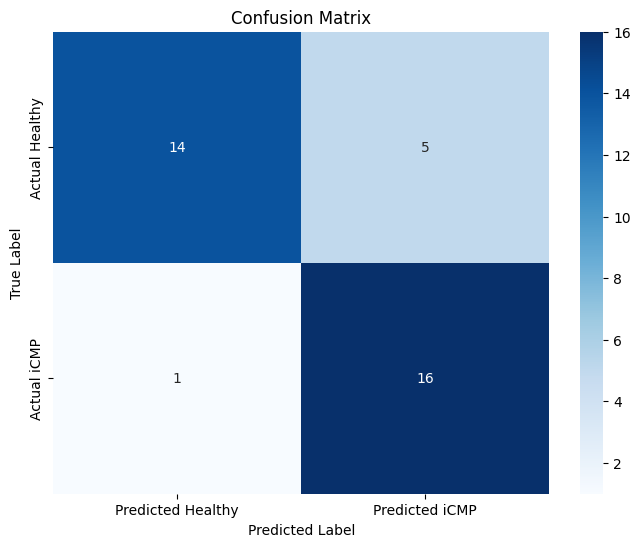

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Example predicted and true labels
predicted_labels = pred_y
true_labels = true_y

# Compute confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix using Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d',
            xticklabels=['Predicted Healthy', 'Predicted iCMP'],
            yticklabels=['Actual Healthy', 'Actual iCMP'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Extracting individual components from the confusion matrix
TN, FP, FN, TP = conf_matrix.ravel()

# Calculating sensitivity and specificity
sensitivity = TP / (TP + FN)
specificity = TN / (TN + FP)

sensitivity, specificity

(0.9411764705882353, 0.7368421052631579)

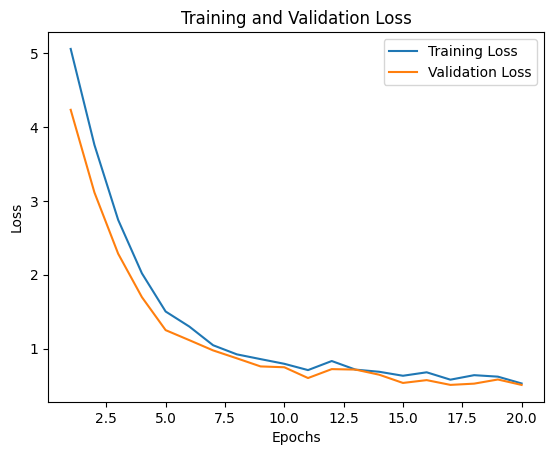

In [ ]:
# Get the training and validation accuracy from the history object
train_accuracy = history.history['loss']
val_accuracy = history.history['val_loss']

# Create an array of epoch numbers for x-axis
epochs_range = range(1, len(train_accuracy) + 1)

# Plot training and validation accuracy
plt.plot(epochs_range, train_accuracy, label='Training Loss')
plt.plot(epochs_range, val_accuracy, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

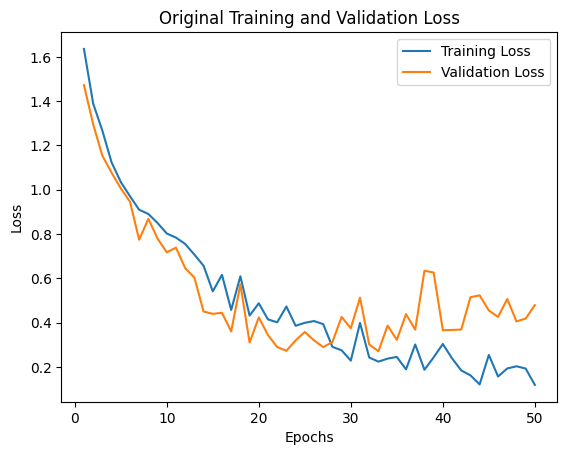

In [ ]:
# Get the training and validation accuracy from the history object
train_accuracy = history.history['loss']
val_accuracy = history.history['val_loss']

# Create an array of epoch numbers for x-axis
epochs_range = range(1, len(train_accuracy) + 1)

# Plot training and validation accuracy
plt.plot(epochs_range, train_accuracy, label='Training Loss')
plt.plot(epochs_range, val_accuracy, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Original Training and Validation Loss')
plt.legend()
plt.show()